In [1]:
from utils import load_dtrajs_from_npz

In [2]:
raw_dtrajs_abl = load_dtrajs_from_npz('dtrajs/abl_11400_2000_dtrajs.npz')
raw_dtrajs_src = load_dtrajs_from_npz('dtrajs/src_11401_2000_dtrajs.npz')

In [194]:
import pyemma
its = pyemma.msm.its(raw_dtrajs_abl,nits=10)

estimating MaximumLikelihoodMSM: 100% (15/15) [####################] eta 00:22 |09-02-16 14:09:24 pyemma.msm.estimators.implied_timescales.ImpliedTimescales[1] WARNING  Estimation has failed at lagtimes: [  8  12  18  27  41  62  93 140 210 315 473]. Run single-lag estimation at these lags to track down the error.
Traceback (most recent call last):
  File "/Users/joshuafass/anaconda/envs/py27/lib/python2.7/site-packages/IPython/core/ultratb.py", line 970, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/Users/joshuafass/anaconda/envs/py27/lib/python2.7/site-packages/IPython/core/ultratb.py", line 233, in wrapped
    return f(*args, **kwargs)
  File "/Users/joshuafass/anaconda/envs/py27/lib/python2.7/site-packages/IPython/core/ultratb.py", line 267, in _fixed_getinnerframes
    records = fix_frame_records_filenames(inspect.getinnerframes(etb, context))
  File "/Users/joshuafass/anaconda/envs/py27/lib/python2.7/inspect.py", line 1049, i

ERROR: Internal Python error in the inspect module.
Below is the traceback from this internal error.


Unfortunately, your original traceback can not be constructed.



TypeError: 'NoneType' object is not iterable

In [ ]:
pyemma.plots.plot_implied_timescales(its)

In [3]:
def trim_dtrajs(dtrajs,length_to_discard=10,min_length=100):
   ''' Ignore trajectories under a specified length, and discard
   the initial frames of the remainder.

   Parameters
   ----------
   dtrajs : list of arrays

   length_to_discard : int, optional
   min_length : int, optional

   Returns
   -------
   trimmed : list of arrays
   '''
   trimmed = [traj[length_to_discard:] for traj in dtrajs if len(traj)>length_to_discard]
   return trimmed

In [4]:
dtrajs_abl = trim_dtrajs(raw_dtrajs_abl)
dtrajs_src = trim_dtrajs(raw_dtrajs_src)

In [5]:
import numpy as np
import mdtraj as md
from pyemma import msm
import pyemma.plots as mplt
import matplotlib.pyplot as plt
import numpy.random as npr
plt.rc('font',family='serif')
%matplotlib inline

In [12]:
import msmbuilder
import msmbuilder.msm
lag_frames = 10
ergodic_cutoff_in_frames=20
ergodic_cutoff = 1.0*ergodic_cutoff_in_frames/lag_frames

In [13]:
mb_msm_abl = msmbuilder.msm.MarkovStateModel(lag_time=lag_frames,
                                             reversible_type='transpose',
                                             #ergodic_cutoff=True,
                                             ergodic_cutoff='off')
mb_msm_abl.fit(dtrajs_abl)
print(mb_msm_abl.summarize())

Markov state model
------------------
Lag time         : 10
Reversible type  : transpose
Ergodic cutoff   : off
Prior counts     : 0

Number of states : 1999
Number of nonzero entries in counts matrix : 26063 (0.652227064007%)
Nonzero counts matrix entries:
    Min.   : 0.1
    1st Qu.: 0.1
    Median : 0.2
    Mean   : 3.1
    3rd Qu.: 0.7
    Max.   : 6960.4

Total transition counts :
    80217.7 counts
Total transition counts / lag_time:
    8021.77 units
Timescales:
    [6407.20, 4536.04, 4087.42, 2715.72, 2677.29, 2659.56, 2584.18, 2336.14, 2318.56, 2247.43, 1868.03, 1832.62, 1823.64, 1714.19, 1704.25, 1673.88, 1562.89, 1529.99, 1449.86, 1442.25, 1360.85, 1269.45, 1169.76, 1159.71, 1148.04, 1068.91, 1053.60, 1023.00, 989.88, 973.44, 921.52, 912.42, 893.05, 870.87, 857.14, 846.06, 839.23, 836.32, 826.90, 796.22, 787.68, 753.41, 736.98, 729.18, 726.69, 716.02, 702.41, 696.28, 693.90, 688.61, 670.96, 668.12, 647.51, 626.06, 618.13, 613.61, 612.12, 604.68, 588.78, 579.38, 562.48, 561.

In [14]:
np.trace(mb_msm_abl.countsmat_)/np.sum(mb_msm_abl.countsmat_)

0.57893582089738249

In [ ]:
'run1-*.h5'

In [192]:
mb_msm_abl = msmbuilder.msm.MarkovStateModel(lag_time=lag_frames,ergodic_cutoff=True)
mb_msm_abl.fit(dtrajs_abl)
print(mb_msm_abl.summarize())

MSM contains 1804 strongly connected components above weight=1.00. Component 29 selected, with population 62.541603%
Markov state model
------------------
Lag time         : 40
Reversible type  : mle
Ergodic cutoff   : True
Prior counts     : 0

Number of states : 90
Number of nonzero entries in counts matrix : 2121 (26.1851851852%)
Nonzero counts matrix entries:
    Min.   : 0.0
    1st Qu.: 0.1
    Median : 0.2
    Mean   : 5.5
    3rd Qu.: 1.1
    Max.   : 1487.5

Total transition counts :
    11584.125 counts
Total transition counts / lag_time:
    289.603125 units
Timescales:
    [933.18, 644.37, 531.64, 506.03, 498.83, 384.65, 382.59, 380.12, 329.89, 324.52, 289.28, 244.04, 242.73, 233.71, 232.48, 229.93, 169.78, 144.94, 130.71, 120.60, 119.42, 105.07, 100.13, 99.85, 92.07, 88.05, 87.89, 85.71, 81.02, 76.14, 75.34, 74.30, 72.33, 71.52, 71.10, 68.02, 61.38, 57.90, 56.89, 56.47, 54.76, 53.46, 52.36, 52.19, 46.25, 45.59, 44.32, 42.03, 40.50, 38.52, 38.13, 36.65, 36.05, 35.51, 34.22,

In [202]:
mb_msm_abl.countsmat_.sum()

11584.125000000002

In [15]:
mb_msm_src = msmbuilder.msm.MarkovStateModel(lag_time=lag_frames,
                                             reversible_type='transpose',
                                             #ergodic_cutoff=True,
                                             ergodic_cutoff='off')
mb_msm_src.fit(dtrajs_src)
print(mb_msm_src.summarize())

Markov state model
------------------
Lag time         : 10
Reversible type  : transpose
Ergodic cutoff   : off
Prior counts     : 0

Number of states : 1998
Number of nonzero entries in counts matrix : 16924 (0.423947470995%)
Nonzero counts matrix entries:
    Min.   : 0.1
    1st Qu.: 0.1
    Median : 0.2
    Mean   : 1.3
    3rd Qu.: 0.7
    Max.   : 383.0

Total transition counts :
    22120.6 counts
Total transition counts / lag_time:
    2212.06 units
Timescales:
    [-2501999792983614.00, -inf, -inf, -inf, 1476590041760813.25, 811459392319003.25, 16390.67, 8933.00, 7456.69, 6818.79, 6325.76, 5641.60, 5462.70, 5079.56, 4953.53, 4165.12, 3993.28, 3598.77, 3205.84, 2978.79, 2952.71, 2808.19, 2547.37, 2462.17, 2407.91, 2289.41, 2169.33, 2122.32, 1979.76, 1907.62, 1783.05, 1742.26, 1586.85, 1581.72, 1531.02, 1471.89, 1465.69, 1447.38, 1333.29, 1300.64, 1270.70, 1258.47, 1233.78, 1225.25, 1175.14, 1150.04, 1131.10, 1117.89, 1116.50, 1105.93, 1046.80, 1021.66, 1008.23, 997.88, 992.12, 

/Users/joshuafass/anaconda/envs/py27/lib/python2.7/site-packages/msmbuilder/msm/core.py:310: RuntimeWarning: invalid value encountered in true_divide
  lv[:, i] = lv[:, i] / np.sqrt(np.dot(lv[:, i], lv[:, i] / lv[:, 0]))
/Users/joshuafass/anaconda/envs/py27/lib/python2.7/site-packages/msmbuilder/msm/core.py:310: RuntimeWarning: divide by zero encountered in true_divide
  lv[:, i] = lv[:, i] / np.sqrt(np.dot(lv[:, i], lv[:, i] / lv[:, 0]))


In [16]:
np.trace(mb_msm_src.countsmat_)/np.sum(mb_msm_src.countsmat_)

0.64017702955616018

In [193]:
mb_msm_src = msmbuilder.msm.MarkovStateModel(lag_time=lag_frames,ergodic_cutoff=True)
mb_msm_src.fit(dtrajs_src)
print(mb_msm_src.summarize())

MSM contains 1933 strongly connected components above weight=1.00. Component 0 selected, with population 20.949523%
Markov state model
------------------
Lag time         : 40
Reversible type  : mle
Ergodic cutoff   : True
Prior counts     : 0

Number of states : 26
Number of nonzero entries in counts matrix : 650 (96.1538461538%)
Nonzero counts matrix entries:
    Min.   : 0.0
    1st Qu.: 0.2
    Median : 0.4
    Mean   : 1.3
    3rd Qu.: 1.1
    Max.   : 61.7

Total transition counts :
    837.175 counts
Total transition counts / lag_time:
    20.929375 units
Timescales:
    [41.44, 38.87, 37.19, 36.22, 35.22, 33.86, 33.25, 31.28, 30.77, 29.02, 28.82, 27.92, 27.41, 25.95, 25.66, 24.38, 24.06, 23.93, 23.37, 21.62, 20.69, 19.34, 18.86, 18.47, 15.05]  units



In [10]:
def plot_relative_free_energies(stationary_distribution,model_name,top_k=50):
   ''' Use stationary distribution to compute the relative
   free energies of the top-k most stable states.

   Parameters
   ----------
   stationary_distribution : array-like
      vector of probabilities
   model_name : string
   top_k : int
   '''
   f_i = -np.log(sorted(stationary_distribution))[::-1];
   f_i -= f_i.min();
   plt.figure()
   plt.plot(f_i[:top_k], '.')
   plt.ylabel(r'Relative free energy ($k_B T \ln \pi_i$)')
   plt.xlabel('State index ($i$)')
   plt.title(model_name)

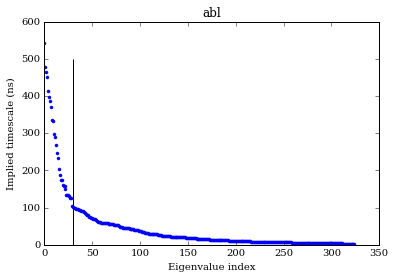

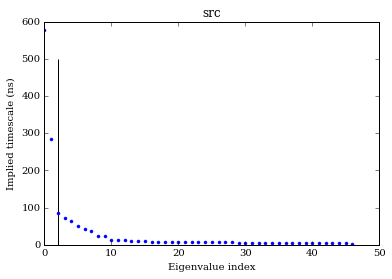

In [154]:
k=1000
convert_to_ns = lambda x:x/4.0

def plot_its(msm,k):
    plt.figure()
    plt.plot(convert_to_ns(msm.timescales_[:k]),'.')
    plt.xlabel('Eigenvalue index')
    plt.ylabel('Implied timescale (ns)')


plot_its(mb_msm_abl,k) # cut at 8
plt.vlines(30,0,500)
plt.title('abl')

plot_its(mb_msm_src,k) # cut at 2?
plt.vlines(2,0,500)
plt.title('src')

In [12]:
# select number of macrostates by how many processes are slower than a threshold
ns_threshold=100

n_macro_abl=sum(convert_to_ns(mb_msm_abl.timescales_[:k])>ns_threshold)
n_macro_src=sum(convert_to_ns(mb_msm_src.timescales_[:k])>ns_threshold)
n_macro_abl,n_macro_src

/Users/joshuafass/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in greater


(31, 2)

"The free energy of metastable state $S_j$ is just $f_j = - ln \sum_{i \in S_j} \pi_i$, where $\pi_i$ is the microstate equilibrium probability"

# macrostates more metastable than 6kB T: 9
Optimization terminated successfully.
         Current function value: -3.651684
         Iterations: 7
         Function evaluations: 580
# macrostates more metastable than 6kB T: 10


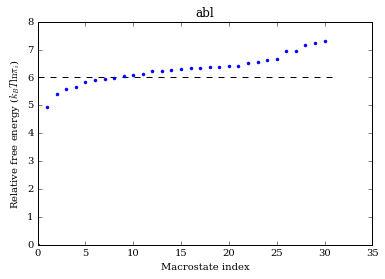

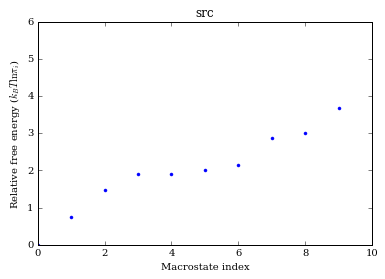

In [207]:
# compute coarse-graining by PCCA+
from msmbuilder import lumping

def coarse_grain_and_plot_energies(msm_obj,n_macro,title,kt_threshold=6):
    pcca = lumping.PCCAPlus.from_msm(msm_obj, n_macrostates=n_macro)
    n_micro=len(pcca.microstate_mapping_)

    # each element of this array is a list of microstate indices corresponding to macrostate indices
    microstates_per_macrostate = np.array([np.arange(n_micro)[pcca.microstate_mapping_==i] for i in range(n_macro)])

    # compute and sort relative macrostate free energies
    macrostate_free_energies = np.array([-np.log(np.sum([msm_obj.populations_[i] for i in microstates])) for microstates in microstates_per_macrostate])
    macrostate_free_energies -= macrostate_free_energies.min()
    macrostate_free_energies = np.array(sorted(macrostate_free_energies))

    # plot, with a threshold of 6kT
    plt.plot(macrostate_free_energies,'.')
    plt.xlabel('Macrostate index')
    plt.ylabel(r'Relative free energy ($k_B T \ln \pi_i$)')
    plt.title(title)
    plt.hlines(kt_threshold,0,n_macro,linestyles='--')

    print('# macrostates more metastable than {0}kB T: {1}'.format(kt_threshold,
                                                                   sum(macrostate_free_energies<kt_threshold)))
    return pcca,macrostate_free_energies


pcca_abl,macrostate_free_energies = coarse_grain_and_plot_energies(mb_msm_abl,n_macro_abl,'abl')
plt.figure()
pcca_src,_ = coarse_grain_and_plot_energies(mb_msm_src,10,'src')

In [ ]:
macrostate_free_energies = np.array([-np.log(np.sum([msm_obj.populations_[i] for i in microstates])) for microstates in microstates_per_macrostate])
macrostate_free_energies -= macrostate_free_energies.min()
macrostate_free_energies = np.array(sorted(macrostate_free_energies))

In [14]:
pcca = pcca_abl
n_macro=31
n_micro=338
microstates_per_macrostate = np.array([np.arange(n_micro)[pcca.microstate_mapping_==i] for i in range(n_macro)])

# compute and sort relative macrostate free energies
macrostate_free_energies = np.array([-np.log(np.sum([mb_msm_abl.populations_[i] for i in microstates])) for microstates in microstates_per_macrostate])
macrostate_free_energies -= macrostate_free_energies.min()

In [15]:
pcca_abl.microstate_mapping_

array([30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
       30, 30, 30, 16, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
       30,  4, 30, 30, 16, 23, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 20,
       30, 30, 30, 23, 30, 30, 30, 30, 24, 30, 30, 30, 30, 30, 30, 30, 11,
       30, 30, 18, 29, 30, 30, 30, 30, 30, 25, 30, 30, 30, 30, 30, 30, 30,
       30, 30, 30, 24, 30, 30, 30, 30, 30, 30, 23, 30, 30, 30, 26, 17, 30,
       13, 30, 10, 29, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,  6, 30, 30,
       30, 30, 17, 28, 30, 30, 30, 30, 30, 30, 30, 11, 30, 30, 30, 30, 30,
       30, 30, 30, 30, 17, 30, 17, 30, 30, 30, 30, 30, 30, 14, 30, 30, 30,
       30, 30, 30, 14, 30, 30, 13,  1, 10, 30, 30, 30, 30, 30, 30, 30,  2,
        8, 30, 16, 30, 30, 30, 30, 30, 30, 29, 30, 30, 30,  9, 30, 30, 16,
       30, 30, 16, 30, 30, 17, 16, 30, 30, 30, 20, 30, 15, 30, 30, 30, 29,
       30, 30, 30, 30,  1, 30, 30, 30, 30, 30, 30, 18, 30, 19, 30, 30, 30,
       30, 22, 30, 30, 27

In [ ]:
macrostate_free_energies

In [ ]:
macrostate_free_energies.max(),np.argmax(macrostate_free_energies)

In [ ]:
most_metastable_macrostate = np.argmax(macrostate_free_energies)
microstate_indices_in_most_metastable_macrostate = microstates_per_macrostate[most_metastable_macrostate]

In [ ]:
microstate_indices_in_most_metastable_macrostate

In [16]:
mb_msm_abl.mapping_

{0: 0,
 1: 1,
 2: 2,
 3: 3,
 5: 4,
 6: 5,
 7: 6,
 9: 7,
 10: 8,
 11: 9,
 14: 10,
 18: 11,
 19: 12,
 23: 13,
 27: 14,
 29: 15,
 33: 16,
 34: 17,
 39: 18,
 40: 19,
 43: 20,
 46: 21,
 51: 22,
 52: 23,
 55: 24,
 60: 25,
 67: 26,
 78: 27,
 86: 28,
 109: 29,
 110: 30,
 119: 31,
 122: 32,
 131: 33,
 136: 34,
 138: 35,
 139: 36,
 140: 37,
 146: 38,
 152: 39,
 168: 40,
 177: 41,
 198: 42,
 201: 43,
 208: 44,
 216: 45,
 224: 46,
 230: 47,
 240: 48,
 244: 49,
 246: 50,
 248: 51,
 273: 52,
 285: 53,
 304: 54,
 313: 55,
 316: 56,
 317: 57,
 319: 58,
 338: 59,
 353: 60,
 370: 61,
 374: 62,
 378: 63,
 401: 64,
 403: 65,
 411: 66,
 412: 67,
 425: 68,
 426: 69,
 434: 70,
 437: 71,
 439: 72,
 445: 73,
 450: 74,
 468: 75,
 469: 76,
 481: 77,
 483: 78,
 484: 79,
 485: 80,
 492: 81,
 503: 82,
 505: 83,
 506: 84,
 507: 85,
 525: 86,
 526: 87,
 527: 88,
 531: 89,
 535: 90,
 548: 91,
 556: 92,
 568: 93,
 570: 94,
 575: 95,
 577: 96,
 595: 97,
 637: 98,
 653: 99,
 677: 100,
 678: 101,
 694: 102,
 699: 103,
 70

In [ ]:
inv_map = {micro: cluster for cluster, micro in mb_msm_abl.mapping_.items()}

In [ ]:
cluster_ids_in_metastable_state = [inv_map[i] for i in microstate_indices_in_most_metastable_macrostate]
cluster_ids_in_metastable_state

In [25]:
# create a length-2000 array and save it, mapping each cluster_id to 
# its metastable state

macrostate_ids_abl = np.zeros(2000)-1

for i in range(len(macrostate_ids)):
    cluster_id = i
    if cluster_id in mb_msm_abl.mapping_:
        microstate_id = mb_msm_abl.mapping_[cluster_id]
        macrostate_id = pcca_abl.microstate_mapping_[microstate_id]
        macrostate_ids_abl[cluster_id] = macrostate_id
        
np.save('macrostate_ids_abl.npy',macrostate_ids_abl)

In [26]:
macrostate_ids_src = np.zeros(2000)-1

for i in range(len(macrostate_ids)):
    cluster_id = i
    if cluster_id in mb_msm_src.mapping_:
        microstate_id = mb_msm_src.mapping_[cluster_id]
        macrostate_id = pcca_src.microstate_mapping_[microstate_id]
        macrostate_ids_src[cluster_id] = macrostate_id
        
np.save('macrostate_ids_src.npy',macrostate_ids_src)

In [23]:
pcca_abl.populations_.shape

(338,)

In [24]:
pcca_abl.microstate_mapping_

array([30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
       30, 30, 30, 16, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
       30,  4, 30, 30, 16, 23, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 20,
       30, 30, 30, 23, 30, 30, 30, 30, 24, 30, 30, 30, 30, 30, 30, 30, 11,
       30, 30, 18, 29, 30, 30, 30, 30, 30, 25, 30, 30, 30, 30, 30, 30, 30,
       30, 30, 30, 24, 30, 30, 30, 30, 30, 30, 23, 30, 30, 30, 26, 17, 30,
       13, 30, 10, 29, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,  6, 30, 30,
       30, 30, 17, 28, 30, 30, 30, 30, 30, 30, 30, 11, 30, 30, 30, 30, 30,
       30, 30, 30, 30, 17, 30, 17, 30, 30, 30, 30, 30, 30, 14, 30, 30, 30,
       30, 30, 30, 14, 30, 30, 13,  1, 10, 30, 30, 30, 30, 30, 30, 30,  2,
        8, 30, 16, 30, 30, 30, 30, 30, 30, 29, 30, 30, 30,  9, 30, 30, 16,
       30, 30, 16, 30, 30, 17, 16, 30, 30, 30, 20, 30, 15, 30, 30, 30, 29,
       30, 30, 30, 30,  1, 30, 30, 30, 30, 30, 30, 18, 30, 19, 30, 30, 30,
       30, 22, 30, 30, 27

In [21]:

for macrostate in range(pcca_abl.n_macrostates):
    pcca_abl.populations_

In [18]:
macrostate_ids

array([ 30.,  30.,  30., ...,   8.,  -1.,  30.])

In [ ]:
# map 

In [ ]:
for i in cluster_ids_in_metastable_state:
    print(1.0*np.sum(np.hstack(dtrajs_abl)==i)/len(np.hstack(dtrajs_abl)))

In [33]:
# get microstate populations

populations_abl = np.zeros(2000)
for i in mb_msm_abl.mapping_:
    populations_abl[i] = mb_msm_abl.populations_[mb_msm_abl.mapping_[i]]

# select most populous microstate within each macrostate
n_macro = pcca_abl.n_macrostates
exemplar_inds_abl = np.zeros(n_macro,dtype=int)
for i in range(n_macro):
    exemplar_inds_abl[i] = np.argmax(populations_abl*(macrostate_ids_abl==i))
    
    
populations_src = np.zeros(2000)
for i in mb_msm_src.mapping_:
    populations_src[i] = mb_msm_src.populations_[mb_msm_src.mapping_[i]]

# select most populous microstate within each macrostate
n_macro = pcca_src.n_macrostates
exemplar_inds_src = np.zeros(n_macro,dtype=int)
for i in range(n_macro):
    exemplar_inds_src[i] = np.argmax(populations_src*(macrostate_ids_src==i))

In [34]:
exemplar_inds_src

array([ 283, 1644,  961, 1034,  711,  659, 1503,  418,  952,    0])

In [35]:
np.save('exemplar_inds_abl.npy',exemplar_inds_abl)
np.save('exemplar_inds_src.npy',exemplar_inds_src)

In [61]:
def cg_T(microstate_T,microstate_pi, cg_map):
    ''' Coarse-grain a microstate transition matrix by applying cg_map
    Parameters
    ----------
    microstate_T : (N,N), array-like, square
       microstate transition matrix
    microstate_pi : (N,), array-like
       microstate stationary distribution
    cg_map : array-like
     assigns each microstate i to a macrostate cg_map[i]
    Returns
    -------
    T : numpy.ndarray, square
    '''

    n_macrostates = np.max(cg_map)+1
    n_microstates = len(microstate_T)

    # compute macrostate stationary distribution
    macrostate_pi = np.zeros(n_macrostates)
    for i in range(n_microstates):
        macrostate_pi[cg_map[i]] += microstate_pi[i]
    macrostate_pi /= np.sum(macrostate_pi)
    
    # accumulate macrostate transition matrix
    T = np.zeros((n_macrostates,n_macrostates))
    for i in range(n_microstates):
        for j in range(n_microstates):
            T[cg_map[i],cg_map[j]] += microstate_pi[i] * microstate_T[i,j]
    
    # normalize
    for a in range(n_macrostates):
        T[a] /= macrostate_pi[a]
     
    return T

In [62]:
T = cg_T(mb_msm_abl.transmat_,mb_msm_abl.populations_,pcca_abl.microstate_mapping_)

In [155]:
pcca_metastability = np.trace(T)
pcca_metastability

29.346505720013756

In [200]:
np.trace(T)/len(T),len(T)

(0.94666147483915342, 31)

In [201]:
np.diag(T)

array([ 0.90373621,  0.92343297,  0.949474  ,  0.9273743 ,  0.93300654,
        0.93867215,  0.94648262,  0.94423077,  0.94799074,  0.90860215,
        0.92981237,  0.94225842,  0.92405063,  0.95832114,  0.94260642,
        0.92767599,  0.96714093,  0.96634211,  0.92729844,  0.9672619 ,
        0.91223547,  0.96997686,  0.95128691,  0.96059727,  0.94786482,
        0.97341211,  0.97399329,  0.98003112,  0.93288737,  0.97365184,
        0.99479787])

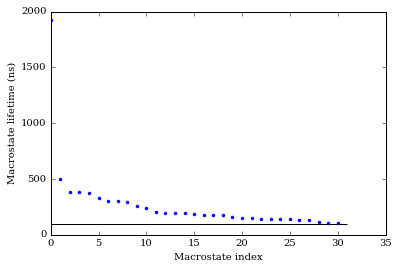

In [210]:
lifetimes = 10/(1-np.diag(T))
plt.plot(np.array(sorted(lifetimes)[::-1]),'.')
plt.xlabel('Macrostate index')
plt.ylabel("Macrostate lifetime (ns)")
plt.hlines(100,0,len(T))

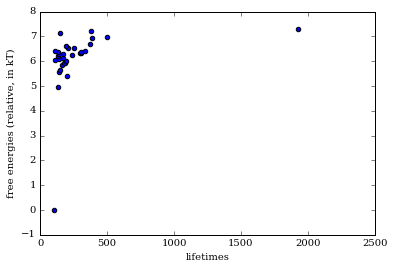

In [213]:
plt.scatter(lifetimes,macrostate_free_energies)
plt.xlabel('lifetimes')
plt.ylabel('free energies (relative, in kT)')

In [148]:
import sys
sys.path.append("../../automatic-state-decomposition/decompose-py/")

import lumping
reload(lumping)



<module 'lumping' from '../../automatic-state-decomposition/decompose-py/lumping.py'>

In [150]:
cgs = []

for i in range(5):
    print(i)
    cg = lumping.CoarseGrain(n_macro_abl,max_iter=100000)
    cg.fit(mb_msm_abl.transmat_,mb_msm_abl.populations_,
                       init_cg_map=pcca_abl.microstate_mapping_
                      )
    cgs.append(cg)

0
Successfully JIT-compiled inner loop! :)
Optimization complete: coarse-grained metastability = 0.917
1
Successfully JIT-compiled inner loop! :)
Optimization complete: coarse-grained metastability = 0.915
2
Successfully JIT-compiled inner loop! :)
Optimization complete: coarse-grained metastability = 0.918
3
Successfully JIT-compiled inner loop! :)
Optimization complete: coarse-grained metastability = 0.921
4
Successfully JIT-compiled inner loop! :)
Optimization complete: coarse-grained metastability = 0.915


(0, 100001)

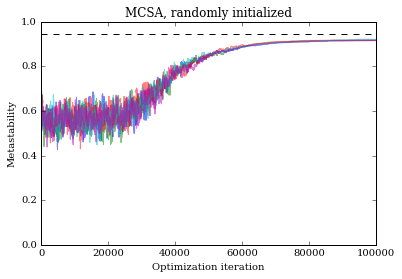

In [151]:
for cg in cgs:
    plt.plot(cg.optimization_trace,alpha=0.5)
plt.xlabel('Optimization iteration')
plt.ylabel('Metastability')
plt.title('MCSA, randomly initialized')
plt.ylim(0,1)
plt.hlines(pcca_metastability,0,len(cgs[0].optimization_trace),linestyles='--')
plt.xlim(0,len(cgs[0].optimization_trace))

In [153]:
pcca_abl.n_macrostates

31

In [156]:
cg = cgs[0]
cg.solns[-1],pcca_abl.microstate_mapping_

((array([30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
         30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
         30,  3, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 18,
         30, 30, 30, 30, 29, 30, 30, 30, 26, 30, 30, 30, 30, 30, 30, 18, 29,
         30, 30, 30, 14,  5, 30, 30, 30, 30, 22, 30, 25, 30, 30, 30, 30, 23,
         30, 30, 10, 30, 23, 30, 30, 30, 30, 30, 30, 30, 27, 30,  2,  1, 17,
         13, 30, 30, 30, 30, 30, 30, 30, 30, 30, 23, 30, 30, 30, 30, 30, 30,
         30, 30, 24,  6, 30, 30, 14, 30, 30, 30, 30, 29, 11, 30, 10, 30, 30,
         16, 30, 30, 30, 24, 30,  1, 30, 30, 30, 30, 16, 30, 23, 30, 30, 30,
         30,  6, 30, 23, 30, 28, 13, 29, 30, 30, 22, 30, 30, 30, 30,  0, 30,
         17, 30, 30,  8, 30,  2, 30, 30, 30, 30, 30, 30, 30, 12, 30, 30, 30,
         30, 30, 30, 30, 30, 24, 30, 30, 30, 30, 18, 30, 10, 30, 30, 30, 30,
         30, 30, 26, 30, 29, 16, 30, 30, 30, 30, 16, 30, 30, 28, 30, 30, 30,

In [161]:
mcsa_microstate_mapping_ = cgs[3].solns[-1][0]

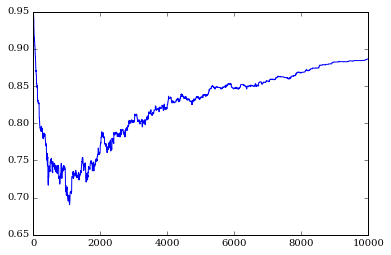

In [36]:
# PCCA object instructs me to transform dtrajs into coarse-grained dtrajs and fit a new markov state model
# to get coarse-grained transition matrix...
def pcca_T(pcca_obj,dtrajs):
    macrostate_dtrajs = []
    for dtraj in dtrajs:
        m_dtraj = np.zeros(len(dtraj),dtype=int)
        for i in range(len(m_dtraj)):
            m_dtraj[i] = pcca_obj.microstate_mapping_[pcca_obj.mapping_[dtraj[i]]]
        macrostate_dtrajs.append(m_dtraj)
    M = msmbuilder.msm.MarkovStateModel()
    M.fit(macrostate_dtrajs)
    T = M.transmat_
    return T

In [37]:
# but this yields errors, since some cluster IDs are not included due to ergodic trimming
T = pcca_T(pcca_abl,dtrajs_abl)

KeyError: 1798

In [164]:
# re-do with MCSA outputs

# create a length-2000 array and save it, mapping each cluster_id to 
# its metastable state

def get_macrostate_ids(mapping):
    macrostate_ids_abl = np.zeros(2000)-1

    for i in range(len(macrostate_ids)):
        cluster_id = i
        if cluster_id in mb_msm_abl.mapping_:
            microstate_id = mb_msm_abl.mapping_[cluster_id]
            macrostate_id = mapping[microstate_id]
            macrostate_ids_abl[cluster_id] = macrostate_id
    return macrostate_ids_abl
        
mcsa_macrostate_ids_abl = get_macrostate_ids(mcsa_microstate_mapping_)
np.save('mcsa_macrostate_ids_abl.npy',mcsa_macrostate_ids_abl)


# select most populous microstate within each macrostate
n_macro = pcca_abl.n_macrostates
exemplar_inds_abl = np.zeros(n_macro,dtype=int)
for i in range(n_macro):
    exemplar_inds_abl[i] = np.argmax(populations_abl*(mcsa_macrostate_ids_abl==i))
np.save('mcsa_exemplar_inds_abl.npy',exemplar_inds_abl)

In [166]:
populations_abl.shape

(2000,)

In [168]:
exemplar_inds_abl

array([ 961, 1725, 1569, 1405, 1898,  595,  653,  138, 1320, 1973,  304,
        850, 1211, 1642,  338, 1847,  246,  888,  830, 1650,  437, 1025,
       1997, 1429, 1949, 1502, 1117,  694,  481, 1030,    7])

In [169]:
# compute and sort relative macrostate free energies
msm_obj = mb_msm_abl

# each element of this array is a list of microstate indices corresponding to macrostate indices
microstates_per_macrostate = np.array([np.arange(n_micro)[mcsa_microstate_mapping_==i] for i in range(n_macro)])
macrostate_free_energies = np.array([-np.log(np.sum([msm_obj.populations_[i] for i in microstates])) for microstates in microstates_per_macrostate])
macrostate_free_energies -= macrostate_free_energies.min()

In [170]:
macrostate_free_energies

array([ 5.77429534,  5.11527956,  5.47148066,  5.68686597,  6.33920877,
        5.87530528,  4.89271818,  6.43466333,  5.77549907,  6.18671532,
        5.96232218,  5.55776281,  6.15667505,  6.36365852,  5.26487725,
        6.55296818,  4.64284675,  5.52519377,  4.80971766,  6.76810965,
        5.41980987,  5.78754479,  6.15920248,  5.04113936,  5.68306553,
        6.0584573 ,  5.61004438,  6.08021894,  5.30927166,  5.25697888,  0.        ])

In [176]:
sorted_inds = np.array(sorted(np.arange(len(exemplar_inds_abl)),key=lambda i:macrostate_free_energies[i]))

In [177]:
macrostate_free_energies[sorted_inds]

array([ 0.        ,  4.64284675,  4.80971766,  4.89271818,  5.04113936,
        5.11527956,  5.25697888,  5.26487725,  5.30927166,  5.41980987,
        5.47148066,  5.52519377,  5.55776281,  5.61004438,  5.68306553,
        5.68686597,  5.77429534,  5.77549907,  5.78754479,  5.87530528,
        5.96232218,  6.0584573 ,  6.08021894,  6.15667505,  6.15920248,
        6.18671532,  6.33920877,  6.36365852,  6.43466333,  6.55296818,
        6.76810965])

In [178]:
exemplar_inds_abl[sorted_inds]

array([   7,  246,  830,  653, 1429, 1725, 1030,  338,  481,  437, 1569,
        888,  850, 1117, 1949, 1405,  961, 1320, 1025,  595,  304, 1502,
        694, 1211, 1997, 1973, 1898, 1642,  138, 1847, 1650])

In [183]:
zip([float('{0:.2f}'.format(x)) for x in macrostate_free_energies[sorted_inds]],exemplar_inds_abl[sorted_inds])

[(0.0, 7),
 (4.64, 246),
 (4.81, 830),
 (4.89, 653),
 (5.04, 1429),
 (5.12, 1725),
 (5.26, 1030),
 (5.26, 338),
 (5.31, 481),
 (5.42, 437),
 (5.47, 1569),
 (5.53, 888),
 (5.56, 850),
 (5.61, 1117),
 (5.68, 1949),
 (5.69, 1405),
 (5.77, 961),
 (5.78, 1320),
 (5.79, 1025),
 (5.88, 595),
 (5.96, 304),
 (6.06, 1502),
 (6.08, 694),
 (6.16, 1211),
 (6.16, 1997),
 (6.19, 1973),
 (6.34, 1898),
 (6.36, 1642),
 (6.43, 138),
 (6.55, 1847),
 (6.77, 1650)]

In [ ]:
free_energy_by_macrostate = []
for i in range(len(exemplar_inds)):
    
    free_energy_by_macrostate.append()